Please note that in my code I used the code provided in the lecture notes and section notes

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import math
import re
import statsmodels.api as sm
import sys
from IPython.display import display


# 1 solve by maximum likelihood

Read in the data the same way Moriarty did

In [2]:
with open('w07-data.tbl') as f:
    # First header line gives us the time points
    fields = f.readline().split()
    X = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        X.append(int(match.group(1)))
    X = np.array(X)
    N = len(X)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()
    S_true = np.zeros(N)
    for i,s in enumerate(fields[1:]):
        match = re.search(r'^\+-(\d+)', s)
        S_true[i] = float(match.group(1))

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    Y = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        Y.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(Y)


The objective function is the negative likelyhood and will then be handled to a minizmier (optimize.minimize)
Here we do the assumptions that each gene level of expression is indepedants.


for each gene we do try to find the parameters b,a and ϕ that better fit the TPM level at differenet time and different sigma
yt = b + a sin(2πω(t + ϕ)) 

In [3]:
def nll(params, sigma=S_true, xs=X , ys=X):
    b = params[0]
    a = params[1]
    phi = params[2]
    ll=0
    for i in range(0,len(X)): 
        y_pred = b + a*np.sin(2*math.pi/24*(xs[i]+phi)) #yt = b + a sin(2πω(t + ϕ)) 
        residual = ys[i] - y_pred #ys[i] is the observed data -  y_pred is what is predicted with the model yt = b + a sin(2πω(t + ϕ)) 
        ll += stats.norm.logpdf(residual, loc=0, scale=sigma[i]) #vary sigma-Not fixed 
        
    return -ll

In [4]:
def one_run(): 
    b_results=[]#initialize 
    a_results=[]
    phi_results=[]
    nll_results=[]
    params_initial = np.array([ 0.,0.,0. ])#primary initialization 
    upper_bound=10000#arbiritary large number
    params_initial[0]=np.random.choice(range(0,upper_bound))#b initialization -the limit that i set is a upper_bound(just a big number)
    params_initial[1]=np.random.choice(range(0,upper_bound))#a initialization
    params_initial[2]=np.random.choice(range(0,24))#phi - between 0 and 24
    for i in range(0,12): # -loop over 12 genes
        result = optimize.minimize(nll, params_initial, (S_true,X,Y[i]) , bounds = [(None,None), (None,None), (None,None)])
        #for now im not passing any bounds- will take care of the contrainsts later in my code 
        nll_result=result.fun #this is the negative likelyhood for the gene i 
        
        b_pred=result.x[0] 
        a_pred=result.x[1]
        phi_pred=result.x[2] 
        if a_pred < 0:                               # there's a symmetry in the solution we have to deal with.
            a_pred  = -a_pred #to correct for negative a- a is a tpm cant be <0
            phi_pred += 12#phase shit
        while phi_pred < 0:  phi_pred+= 24 #this is to fullfill the condition phi between 0 and 24 
        while phi_pred > 24: phi_pred -= 24    
        nll_results.append(nll_result) #append the resulting Nll for this gene 
        b_results.append(b_pred) #append the estimate of B for the gene i 
        a_results.append(a_pred)#append the estimate of a for the gene i 
        phi_results.append(phi_pred)#append the estimate of phi for the gene i 
    return(b_results,a_results,phi_results,nll_results)

each time I run the function one_run i obtained 4 arrays 
b_r-a_r-phi_r-nll_r

each of the array has a 12 elements 
b_r/a_r/phi_r are respectively the estimate of the paramter B/A/PHI for each gene in the expression 

yt = b + a sin(2πω(t + ϕ)) 

the nll_r is a measure of how well the estimate fit the observed data - the lower nll_r the better our predictions are for each gene

In [5]:
#run of one_run just to have a better sense of what this function is outputing
b_r,a_r,phi_r,nll_r=one_run()
print('nll',nll_r)#how well the optimizer did for that gene 
print('b',b_r)
print('a',a_r)
print('phi',phi_r)


nll [29.608217511088355, 25.155879962932993, 29.221777787788717, 25.282166626484415, 27.231213433358512, 24.69164779743634, 26.284973733178674, 28.342352489958046, 24.51098498561368, 29.14786423868269, 27.320783269755545, 25.555608451071024]
b [41.082303026946846, 41.62063375960769, 50.21351885169673, 44.482245156550135, 47.12414419320945, 44.96690341139598, 39.553457144020534, 50.2817317924345, 44.80507264353659, 49.846793670205294, 46.01937804151408, 44.54487231316064]
a [24.30625420851893, 23.079456244326337, 18.72886140019111, 27.414503466012466, 27.63147283374711, 20.05586713928101, 30.712750820417302, 23.49896535718388, 21.559355116222136, 34.84467342748499, 26.719465267788227, 24.621468702489988]
phi [0.3255356505936433, 18.28045443430021, 3.7699815519520783, 14.512717453090964, 10.172867447044553, 8.584117247836616, 2.069735028593982, 22.116930639309235, 7.006979714892633, 19.836130899364314, 16.170145041898934, 12.005946312904882]


now we want to restimate for those 12 genes a/b/phi and the nlls many times.

Why? Because when we do so we start with different initial points (thats why the intial points are defined inside the one_run function)we end up with differenent estimate for the parameters a/b and phi 
how do we select the best one? the lower the nll is the better the estimates are - so basically we comapre the nll that we generate with the previously higher nll for each gene. If the current one is lower, for that gene i we replace the saved paramaeter A/b/phi to the one generated in that run(the one with lower nll)
Its similar to what we have done in previous pset

In [6]:
runs_number=10 #arbiratry decided - the higher this number is the lower it will take to run - 10 is ok 
min_nll=np.full(12,float("inf")) #initialise all the initial arrays to be inifinty(for the 12 elemnts)to be able to compare
min_nll=np.full(12,float("inf"))
b_best=np.full(12,float("inf"))
a_best=np.full(12,float("inf"))
phi_best=np.full(12,float("inf"))
for run in range(0,runs_number):
    print("run number:",run+1) #keep track 
    b_r,a_r,phi_r,nll_r=one_run()
    for g in range(0,12): #compare for each gene
        if nll_r[g]<min_nll[g]: #permuation of that gene 
            print('permutation for gene',genenames[g]) #keep track of the permutation made 
            #expect permuation for all genes in the first run 
            min_nll[g]=nll_r[g]
            b_best[g]=b_r[g]
            a_best[g]=a_r[g]
            phi_best[g]=phi_r[g]

run number: 1
permutation for gene anise
permutation for gene kiwi
permutation for gene carrot
permutation for gene grape
permutation for gene tangerine
permutation for gene melon
permutation for gene clementine
permutation for gene spinach
permutation for gene beet
permutation for gene huckleberry
permutation for gene lentil
permutation for gene cauliflower
run number: 2
permutation for gene anise
permutation for gene kiwi
permutation for gene grape
permutation for gene spinach
permutation for gene lentil
run number: 3
permutation for gene anise
permutation for gene melon
permutation for gene spinach
permutation for gene lentil
run number: 4
permutation for gene spinach
permutation for gene cauliflower
run number: 5
permutation for gene grape
permutation for gene clementine
permutation for gene beet
run number: 6
permutation for gene clementine
run number: 7
permutation for gene anise
run number: 8
permutation for gene melon
permutation for gene clementine
run number: 9
permutation fo

In [7]:
##check point
#print('nll,',min_nll)
# print(b_best)
# print(a_best)
# print(phi_best)

In [22]:
## Output
ML_results_dictionary = {'gene': genenames, 
               'B(tpm)': [round(i,2) for i in b_best], 
               'A(tpm)': [round(i,2) for i in a_best], 
               'phi(hr)': [round(i,2) for i in phi_best],
                'nll': [round(i,2) for i in min_nll]  }
ML_result = pd.DataFrame(ML_results_dictionary)
ML_result = ML_result.set_index(['gene'])
ML_result


,B(tpm),A(tpm),phi(hr),nll
gene,,,,
anise,41.08,24.31,0.33,29.61
kiwi,41.62,23.08,18.28,25.16
carrot,50.21,18.73,3.77,29.22
grape,44.48,27.41,14.51,25.28
tangerine,47.12,27.63,10.17,27.23
melon,44.97,20.06,8.58,24.69
clementine,39.55,30.71,2.07,26.28
spinach,50.28,23.50,22.12,28.34
beet,44.81,21.56,7.01,24.51


In [9]:
print('the total log negative likelyhood  for MLE method is ',sum(min_nll))    

the total log negative likelyhood  for MLE method is  322.35347028143786


# 2 compare solutions

In [10]:
#this is copy paste of moriarty code 
b_fit = np.zeros(G)
a_fit = np.zeros(G)
p_fit = np.zeros(G)

b_opt = np.zeros(G)
a_opt = np.zeros(G)
p_opt = np.zeros(G)

for g in range(G):
    # We have to set up a matrix A the way numpy.linalg.lstsq() wants it.
    #
    A = np.zeros((N, 3))  # observations x coefficients
    for i in range(N):
        A[i][0] = 1.
        A[i][1] = np.sin(2. * math.pi * X[i] / 24)  
        A[i][2] = np.cos(2. * math.pi * X[i] / 24)

    try:
        result    = np.linalg.lstsq(A, Y[g])[0]
    except:
        sys.exit("Linear least square fit failed")

    p_fit[g]  = np.arctan(result[2] / result[1])   # in radians at first
    b_fit[g]  = result[0]
    a_fit[g]  = result[1] / np.cos(p_fit[g])

    p_fit[g] = 24 * p_fit[g] / (2 * math.pi)       # now in hours
    
    if a_fit[g] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit[g]  = -a_fit[g]
        p_fit[g] += 12
    while p_fit[g] < 0:  p_fit[g] += 24
    while p_fit[g] > 24: p_fit[g] -= 24



/Users/leinaessakalli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Now LETS estimate Moriaty NLL for each gene - similar to the nll function that is above

In [11]:
Moriartyll=[]

for i in range(12): #for each gene
    ll=0
    a = a_fit[i]
    b = b_fit[i]
    phi = p_fit[i]
    for j in range(0,len(X)): #for each obeservation
        yt_predicted = b + a * np.sin(2*math.pi/24*(X[j]+phi)) #yt = b + a sin(2πω(t + ϕ)) 
        residual = Y[i][j] - yt_predicted
        ll += stats.norm.logpdf(residual, loc=0, scale=S_true[j])
    Moriartyll.append(-ll)   
    
print('the total log negative likelyhood  for Moriarity is ',sum(Moriartyll))

the total log negative likelyhood  for Moriarity is  671.4044850767173


In [12]:
moriarty_results_dictionary = {'gene': genenames, 
               'B(tpm)': [round(i,2) for i in b_fit], 
               'A(tpm)': [round(i,2) for i in a_fit], 
               'phi(hr)': [round(i,2) for i in p_fit],
                'nll': [round(i,2) for i in Moriartyll]}
moriarty_result = pd.DataFrame(moriarty_results_dictionary)
moriarty_result = moriarty_result.set_index(['gene'])
print('Moriarty results')
display(moriarty_result)
print('\n')
print('ML results')
display(ML_result)
b_fit

Moriarty results


,B(tpm),A(tpm),phi(hr),nll
gene,,,,
anise,47.97,29.64,0.22,54.33
kiwi,38.26,31.60,18.78,43.28
carrot,40.55,6.68,1.34,146.51
grape,49.31,35.35,14.63,29.92
tangerine,53.34,30.44,12.02,44.40
melon,45.29,18.41,7.74,28.21
clementine,34.78,29.27,0.85,58.72
spinach,46.97,25.12,20.97,52.62
beet,46.81,25.43,7.82,28.25




ML results


,B(tpm),A(tpm),phi(hr),nll
gene,,,,
anise,41.08,24.31,0.33,29.61
kiwi,41.62,23.08,18.28,25.16
carrot,50.21,18.73,3.77,29.22
grape,44.48,27.41,14.51,25.28
tangerine,47.12,27.63,10.17,27.23
melon,44.97,20.06,8.58,24.69
clementine,39.55,30.71,2.07,26.28
spinach,50.28,23.50,22.12,28.34
beet,44.81,21.56,7.01,24.51


array([47.97416667, 38.25777778, 40.55416667, 49.30916667, 53.34083333,
       45.29055556, 34.78361111, 46.97083333, 46.80916667, 63.29361111,
       41.75305556, 51.18416667])

In [13]:
print("The total log positive likelihood of Moriarty method is: {}".format(-sum(Moriartyll)))
print("The total log positive likelihood using MLE is: {}".format(-sum(min_nll)))

The total log positive likelihood of Moriarty method is: -671.4044850767173
The total log positive likelihood using MLE is: -322.35347028143786


Calculate the total log likelyhood ratio

In [14]:
log_ratio=math.exp(sum(Moriartyll)-sum(min_nll))
print('The MLE method is : {}'.format(log_ratio) ,'better')

The MLE method is : 3.898788068511197e+151 better


WOOW OUR METHOD IS DOING WAYY better than moritaty

# 3 plot the fit

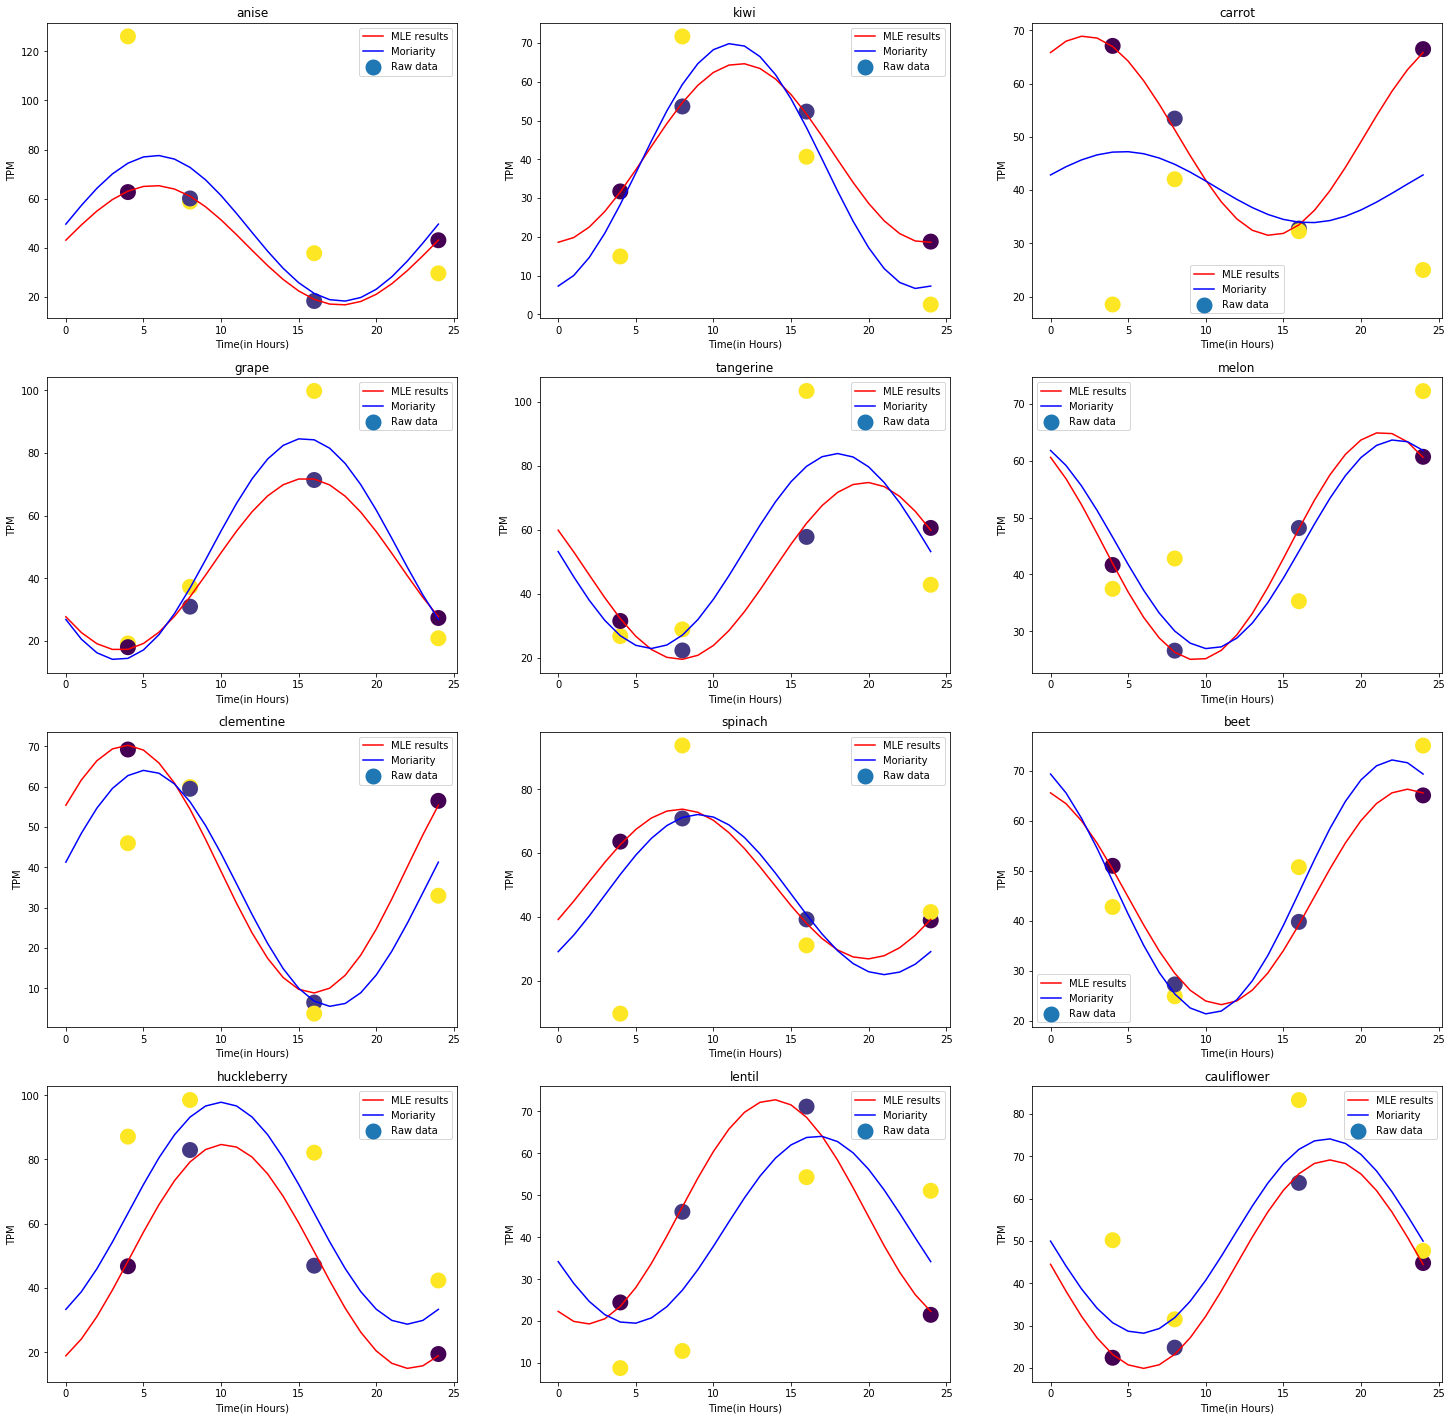

In [15]:
t=np.linspace(0, 24, num=25) #shared for all genes
nb_genes=12
y_ML_reccords=[]
y_Moriarty_reccord=[]
nrows, ncols = 4,3
fig=plt.figure()

for i in range(1,(nb_genes+1)): #the method used in the line bellow only works when i>0 so i-1 correspond to the gene i 
    ax = fig.add_subplot(nrows, ncols, i) #loop over 2d subplot as if it's a 1-D
    y_ML=0 #reinitialise 
    y_moriarty =0
    plt.scatter(X,Y[i-1],c=S_true,linewidths=10,label='Raw data') #row data -observed data
    y_ML=b_best[i-1]+ a_best[i-1]* np.sin(2*math.pi/24*(t+phi_best[i-1])) # mine
    ax.plot(t,y_ML,c='red',label='MLE results') 
    y_moriarty=b_fit[i-1]+ a_fit[i-1]* np.sin(2*math.pi/24*(t+p_fit[i-1]))# moriarty
    ax.plot(t,y_moriarty,c='blue',label='Moriarity')  
    ax.set_title(genenames[i-1])
    ax.legend()
    plt.xlabel('Time(in Hours)')
    plt.ylabel('TPM')
    
fig.set_figheight(25)
fig.set_figwidth(25)    
plt.show()


So we know that our method is better(and in the plots its also obvious that our method better fit the data then then moritaty method)
IS OUR METHOD BETTER BECAUSE WE USED DIFFERENT SIGMA or is it better because we used maximum likelyhood in stead of least sqaure fititng- 
One of the assumption that the least square fitting method is taking(and completly ignored by Moriarty) is that the sigma are uniforms 
the way I want to test my hypohtesis is to set to take into account the sigma in Moriraty code to see how the a/b/phi estimate different and how good our method is doing compare to Moriarty(when he is using the weights for each sigma)

In [16]:
#Modified moritaty code to. include weights 
b_w = np.zeros(G) #weighted - initialisation 
a_w = np.zeros(G)
p_w = np.zeros(G)

for g in range(G):
    
    wls_model=sm.WLS(Y[g],A,weights=1/(S_true**2))
    result_w=wls_model.fit()
    p_w[g]  = np.arctan(result_w.params[2] / result_w.params[1])   # in radians at first
    b_w[g]  = result_w.params[0]
    a_w[g]  = result_w.params[1] / np.cos(p_w[g])

    p_w[g] = 24 * p_w[g] / (2 * math.pi)       # now in hours
    if a_w[g] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_w[g]  = -a_w[g]
        p_w[g] += 12
    while p_w[g] < 0:  p_w[g] += 24
    while p_w[g] > 24: p_w[g] -= 24



In [17]:
#nll as before but this time weighted
weight_nll_Moriarty=[]

for i in range(12): #for 12 gene
    ll=0
    a = a_w[i]
    b = b_w[i]
    p = p_w[i]
    for j in range(len(X)):
        Yt_pred = b + a * np.sin(2*math.pi/24*(X[j]+p)) #yt = b + a sin(2πω(t + ϕ)) 
        residual = Y[i][j] - Yt_pred
        ll += stats.norm.logpdf(residual, loc=0, scale=S_true[j])
    weight_nll_Moriarty.append(-ll) 

In [18]:
sum(weight_nll_Moriarty)

322.3534702814347

In [19]:
print ("The total log likelihood of the weighted OLS method is {}".format(sum(weight_nll_Moriarty)))
print ("The total log likelihood of the MLE method is {}".format(sum(min_nll)))
print("The MLE method is {} times more likely".format(np.exp(sum(min_nll)-sum(weight_nll_Moriarty))))

The total log likelihood of the weighted OLS method is 322.3534702814347
The total log likelihood of the MLE method is 322.35347028143786
The MLE method is 1.0000000000031832 times more likely


At this point we can say that the weighted least square fit method(meaning that we take into account the different sigma) is as good as the ML

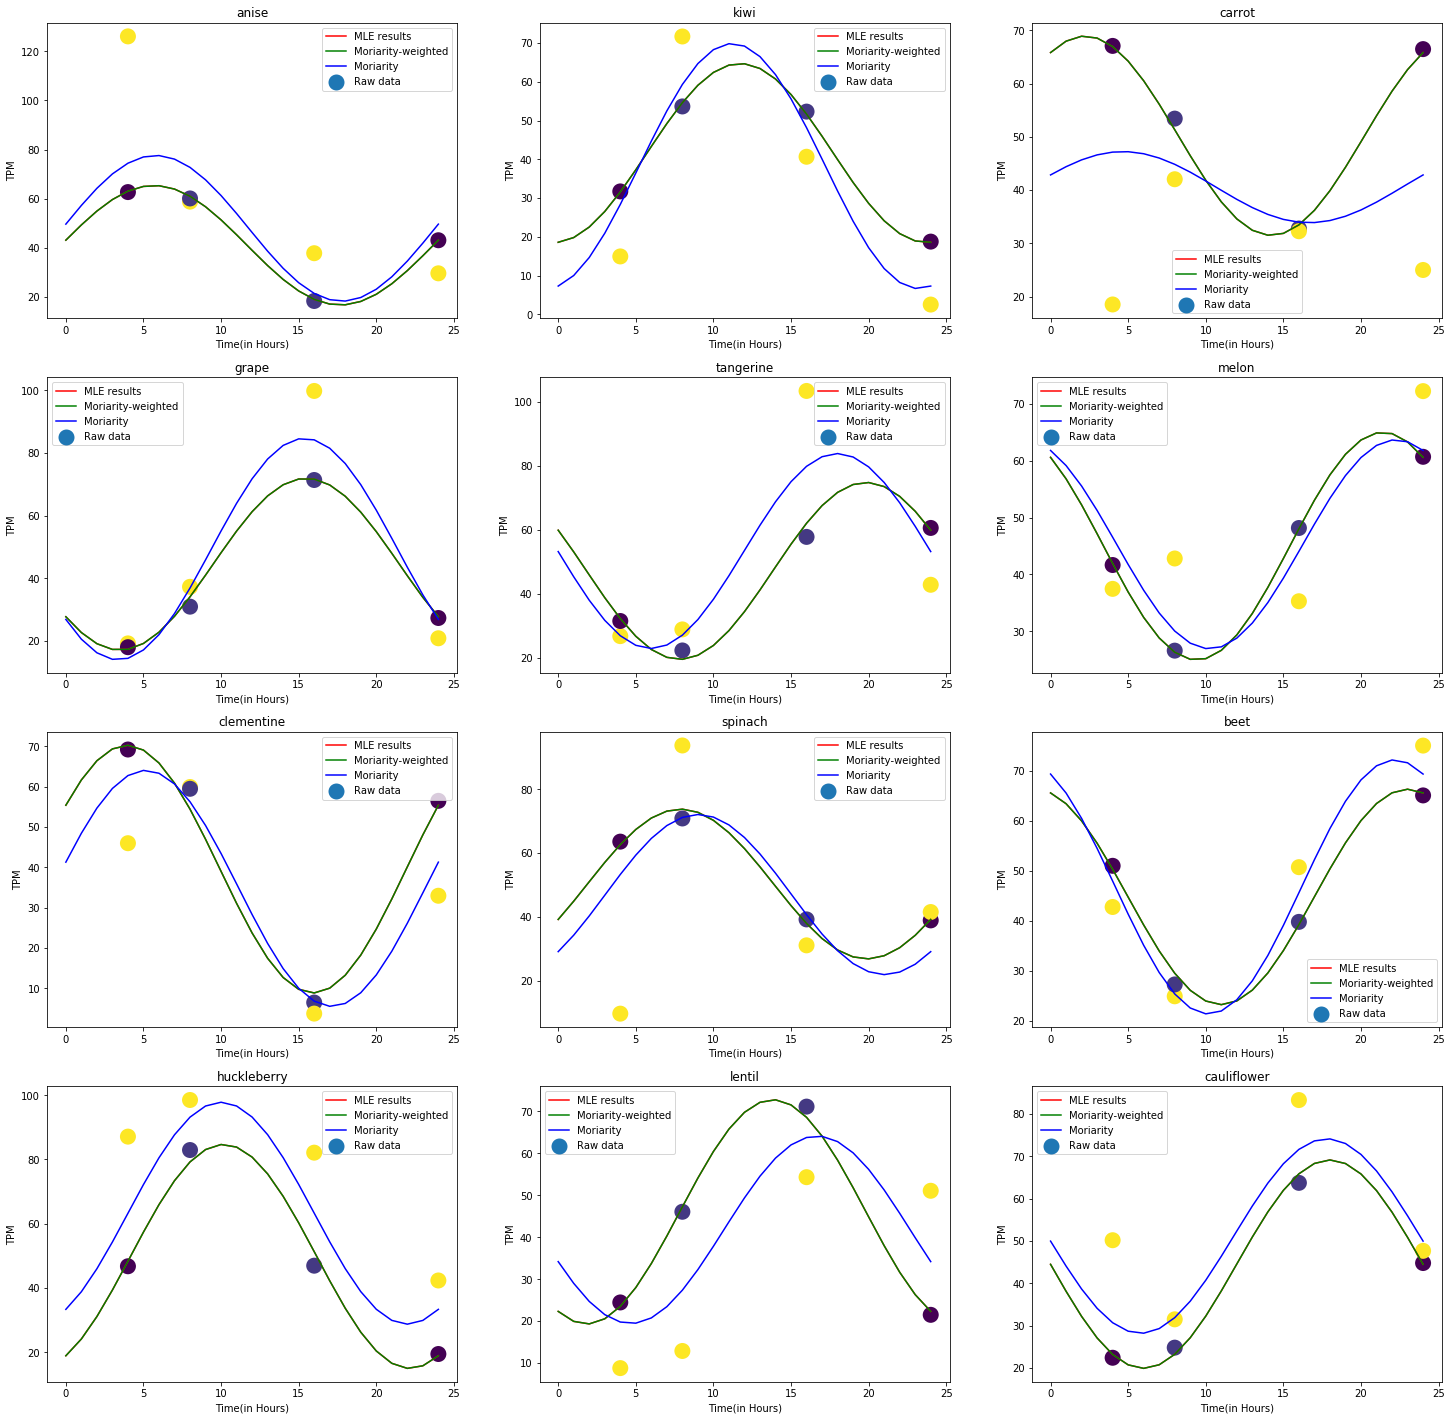

In [20]:
t=np.linspace(0, 24, num=25) #shared for all genes
nb_genes=12
nrows, ncols = 4,3
fig=plt.figure()

for i in range(1,(nb_genes+1)): #the method used in the line bellow only works when i>0 so i-1 correspond to the gene i 
    ax = fig.add_subplot(nrows, ncols, i) #loop over 2d subplot as if it's a 1-D
    y_ML=0 #reinitialise 
    y_moriarty =0
    y_moriarty =0
    y_moriarty_weighted=0
    plt.scatter(X,Y[i-1],c=S_true,linewidths=10,label='Raw data') #row data -observed data
    y_ML=b_best[i-1]+ a_best[i-1]* np.sin(2*math.pi/24*(t+phi_best[i-1])) # mine
    ax.plot(t,y_ML,c='red',label='MLE results') 
    
    y_moriarty_weighted=b_w[i-1]+ a_w[i-1]* np.sin(2*math.pi/24*(t+p_w[i-1]))# moriarty
    ax.plot(t,y_moriarty_weighted,c='green',label='Moriarity-weighted')  
    
    y_moriarty=b_fit[i-1]+ a_fit[i-1]* np.sin(2*math.pi/24*(t+p_fit[i-1]))# moriarty
    ax.plot(t,y_moriarty,c='blue',label='Moriarity')  
    
    ax.set_title(genenames[i-1])
    ax.legend()
    plt.xlabel('Time(in Hours)')
    plt.ylabel('TPM')
    
fig.set_figheight(25)
fig.set_figwidth(25)    
plt.show()



we can wee that the moriarty weighted and the MLE method overlap- they are doing equally well- Moriaty was very close but not taking an account that there are different sigma in the data observed caused him to generate estimates that were super off 